<a href="https://colab.research.google.com/github/yesong98/Exploration/blob/main/Exploration12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#  프로젝트: 뉴스기사 요약해보기
<루브릭>
1. Abstractive 모델 구성을 위한 텍스트 전처리 단계가 체계적으로 진행되었다.  
- 분석단계, 정제단계, 정규화와 불용어 제거, 데이터셋 분리, 인코딩 과정이 빠짐없이 체계적으로 진행되었다.  
2. 텍스트 요약모델이 성공적으로 학습되었음을 확인하였다.  
- 모델 학습이 진행되면서 train loss와 validation loss가 감소하는 경향을 그래프를 통해 확인했으며, 실제 요약문에 있는 핵심 단어들이 요약 문장 안에 포함되었다.  
3. Extractive 요약을 시도해 보고 Abstractive 요약 결과과 함께 비교해 보았다.  
- 두 요약 결과를 문법완성도 측면과 핵심단어 포함 측면으로 나누어 비교하고 분석 결과를 표로 정리하여 제시하였다.  

In [4]:
import nltk
nltk.download('stopwords')

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

from google.colab import drive
drive.mount('/content/drive')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Mounted at /content/drive


# Step 1. 데이터 수집하기
데이터는 아래 링크에 있는 뉴스 기사 데이터(news_summary_more.csv)를 사용하세요.

In [7]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [3]:
data.sample(10)


,headlines,text
19832,Asiad gold winner Vinesh Phogat gets engaged a...,"Vinesh Phogat, who recently became the first I..."
87928,India's population has overtaken China's: Chin...,India has overtaken China to become the world'...
30672,Zomato appoints former GE exec Sameer Maheshwa...,Online restaurant discovery and food-delivery ...
59828,"Union Cabinet approves hike in salary for SC, ...",The Union Cabinet has approved a proposal to h...
57647,Candlelight vigil held in Peshawar to honour S...,A group of people in Pakistan's Peshawar held ...
65491,Shraddha trolled for requesting firecrackers-f...,Actress Shraddha Kapoor has been trolled for u...
66561,White tiger cubs kill caretaker at K'taka Biol...,A 41-year-old caretaker at Karnataka's Bannerg...
49570,School principal's car runs over students in T...,A student was killed and two others were injur...
78240,North Korea conducts new ICBM missile test,North Korea conducted a new intercontinental b...
19347,Kohli takes 1 innings fewer than Sachin to rea...,"India captain Virat Kohli completed 6,000 runs..."


# Step 2. 데이터 전처리하기 (추상적 요약)
실습에서 사용된 전처리를 참고하여 각자 필요하다고 생각하는 전처리를 추가 사용하여 텍스트를 정규화 또는 정제해 보세요. 만약, 불용어 제거를 선택한다면 상대적으로 길이가 짧은 요약 데이터에 대해서도 불용어를 제거하는 것이 좋을지 고민해 보세요.
### 전처리

In [4]:
print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

# inplace=True 를 설정하면 DataFrame 타입 값을 return 하지 않고 data 내부를 직접적으로 바꿉니다
data.drop_duplicates(subset = ['text'], inplace=True)
print('전체 샘플수 :', (len(data)))

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280
전체 샘플수 : 98360


In [5]:
print(data.isnull().sum())
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

headlines    0
text         0
dtype: int64
전체 샘플수 : 98360


### 불용어 제거, 정규화

In [6]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))
print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

정규화 사전의 수:  120
불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', '

In [7]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (Text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (Headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens

In [8]:
#훈련 데이터 전체에 대해 전처리
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 상위 5개의 줄 출력
print("Text 전처리 후 결과: ", clean_text[:5])

clean_headlines = []
# 전체 headlines 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

Text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [9]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

In [10]:
#Null값 확인
data.isnull().sum()

headlines    0
text         0
dtype: int64

In [11]:
#빈 샘플 제거
data.dropna(axis=0, inplace=True)
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 데이터 분리
- 샘플의 최대 길이

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09968483123221
헤드라인의 최소 길이 : 1
헤드라인의 최대 길이 : 16
헤드라인의 평균 길이 : 9.299532330215534


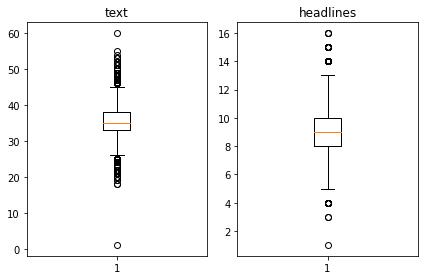

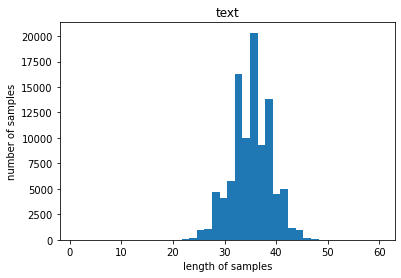

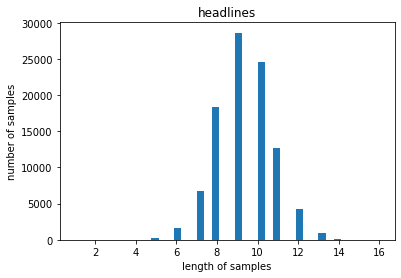

In [12]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('헤드라인의 최소 길이 : {}'.format(np.min(headlines_len)))
print('헤드라인의 최대 길이 : {}'.format(np.max(headlines_len)))
print('헤드라인의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [13]:
#Text의 최대 길이와 Headlines의 적절한 최대 길이 임의로 정하기
text_max_len = 60  #텍스트의 최대 길이
headlines_max_len = 16  #헤드라인의 최대 길이

In [14]:
def below_threshold_len(max_len, nested_list):
    cnt = 0
    for s in nested_list:
        if(len(s.split()) <= max_len):
            cnt = cnt + 1
    print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

In [15]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 60 이하인 샘플의 비율: 1.0
전체 샘플 중 길이가 16 이하인 샘플의 비율: 1.0


In [16]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 98360


### 시작토큰, 종료토큰 정하기


In [17]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
1,delhi techie wins free food from swiggy for on...,kunal shah credit card bill payment platform c...,sostoken delhi techie wins free food from swig...,delhi techie wins free food from swiggy for on...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
4,have known hirani for yrs what if metoo claims...,speaking sexual harassment allegations rajkuma...,sostoken have known hirani for yrs what if met...,have known hirani for yrs what if metoo claims...


In [18]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블

indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[25366 82727 26877 ... 36135  8042 80354]


In [19]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]

n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 19672


In [20]:
encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 78688
훈련 레이블의 개수 : 78688
테스트 데이터의 개수 : 19672
테스트 레이블의 개수 : 19672


### (3) 정수 인코딩
단어 집합(vocabulary) 만들기 및 정수 인코딩

In [21]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성

threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 69472
등장 빈도가 6번 이하인 희귀 단어의 수: 47325
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 22147
단어 집합에서 희귀 단어의 비율: 68.12096959926302
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.4899700206875


In [22]:
src_vocab = 8000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 8,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성

# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[3511, 79, 5434, 978, 1102, 307, 6184, 508, 1, 1938, 681, 849, 1547, 1837, 1977, 1946, 862, 7639, 1216, 392, 1547, 978, 2464, 322, 4], [11, 1525, 306, 1283, 415, 2410, 41, 730, 409, 3757, 1168, 66, 361, 824, 425, 3107, 1221, 1738, 1674, 1997, 1283, 221, 269, 508, 2410, 66, 6, 755, 3107, 1221, 30, 3, 13, 206, 317, 5223, 4100], [11, 5124, 1714, 5324, 4693, 1, 2, 187, 4656, 3259, 909, 2926, 103, 660, 561, 493, 1564, 1969, 1226, 1, 2, 92, 1838, 184, 133, 140, 873, 339, 1492, 352, 8, 4693, 1, 26, 2139, 387, 664, 4179, 1062]]


In [23]:
tar_tokenizer = Tokenizer()
tar_tokenizer.fit_on_texts(decoder_input_train)

threshold = 6
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 30050
등장 빈도가 5번 이하인 희귀 단어의 수: 19638
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10412
단어 집합에서 희귀 단어의 비율: 65.35108153078203
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.648806732643944


In [24]:
tar_vocab = 2000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 49, 736, 10, 1395, 17, 759], [1, 28, 1961, 286, 544, 201, 1929, 4, 1993], [1, 8, 772, 4, 596, 128], [1, 278, 39, 26, 950, 4, 867], [1, 1721, 1686, 1704, 29, 42, 440]]
target
decoder  [[49, 736, 10, 1395, 17, 759, 2], [28, 1961, 286, 544, 201, 1929, 4, 1993, 2], [8, 772, 4, 596, 128, 2], [278, 39, 26, 950, 4, 867, 2], [1721, 1686, 1704, 29, 42, 440, 2]]


In [25]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 13
삭제할 테스트 데이터의 개수 : 2
훈련 데이터의 개수 : 78675
훈련 레이블의 개수 : 78675
테스트 데이터의 개수 : 19670
테스트 레이블의 개수 : 19670


In [26]:
# 패딩
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')

## 모델 설계

In [27]:
#함수형 API
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

In [28]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

In [29]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                              

# Step 3. 어텐션 메커니즘 사용하기 (추상적 요약)
일반적인 seq2seq보다는 어텐션 메커니즘을 사용한 seq2seq를 사용하는 것이 더 나은 성능을 얻을 수 있어요. 실습 내용을 참고하여 어텐션 메커니즘을 사용한 seq2seq를 설계해 보세요.

In [30]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 60, 128)      1024000     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 60, 256),    394240      ['embedding[0][0]']              
                                 (None, 256),                                                     
                                 (None, 256)]                                                     
                                                                                            

### 모델훈련

In [31]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
308/308 [==============================] - 244s 756ms/step - loss: 2.9518 - val_loss: 2.6885
Epoch 2/50
308/308 [==============================] - 232s 753ms/step - loss: 2.5664 - val_loss: 2.4305
Epoch 3/50
308/308 [==============================] - 239s 776ms/step - loss: 2.3441 - val_loss: 2.2750
Epoch 4/50
308/308 [==============================] - 234s 759ms/step - loss: 2.2029 - val_loss: 2.1656
Epoch 5/50
308/308 [==============================] - 232s 753ms/step - loss: 2.1023 - val_loss: 2.0967
Epoch 6/50
308/308 [==============================] - 233s 757ms/step - loss: 2.0229 - val_loss: 2.0395
Epoch 7/50
308/308 [==============================] - 231s 750ms/step - loss: 1.9561 - val_loss: 1.9936
Epoch 8/50
308/308 [==============================] - 232s 754ms/step - loss: 1.8987 - val_loss: 1.9556
Epoch 9/50
308/308 [==============================] - 231s 747ms/step - loss: 1.8484 - val_loss: 1.9223
Epoch 10/50
308/308 [==============================] - 230s 747m

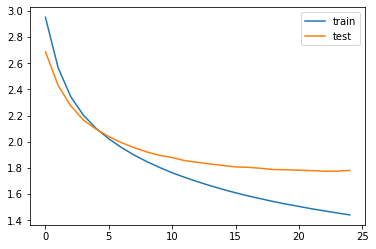

In [32]:
#시각화
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

## 인퍼런스 구현

In [35]:
#텍스트 데이터 복원을 위해 3개 사전 정의
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음

In [38]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.

decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])
                                                                             

In [39]:
#어텐션 메커니즘을 사용하는 출력층 설계
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [40]:
#인퍼런스 단계에서 단어 시퀀스를 완성하는 함수
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (headlines_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence

#Step 4. 실제 결과와 요약문 비교하기 (추상적 요약)
원래의 요약문(headlines 열)과 학습을 통해 얻은 추상적 요약의 결과를 비교해 보세요.

In [41]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2headlines(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [42]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2headlines(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : technology giant google pledged crore relief restoration work kerala due floods company india vp rajan said tuesday google crisis response team also launched several measures help people affected floods earlier apple announced crore donation towards ongoing relief work flood hit kerala 
실제 요약 : after apple google crore for kerala flood relief 
예측 요약 :  google to kerala floods relief for kerala floods


원문 : migrants right choose host nation un refugee agency said added nations save lives afford protection refugees hailed efforts european nations including france germany italy processing asylum around refugees migrants stranded 
실제 요약 : migrants do not have right to host nation un 
예측 요약 :  nations can lose to nations


원문 : french president emmanuel macron said britain decision quit european union yes vote mistake french people would voted leave eu presented similar choice vote referendum added macron said would welcome britain decision bloc 
실제 요약 : brexit through or no mistake f

#Step 5. Summa을 이용해서 추출적 요약해보기
추상적 요약은 추출적 요약과는 달리 문장의 표현력을 다양하게 가져갈 수 있지만, 추출적 요약에 비해서 난이도가 높다. 반대로 말하면 추출적 요약은 추상적 요약에 비해 난이도가 낮고 기존 문장에서 문장을 꺼내오는 것이므로 잘못된 요약이 나올 가능성이 낮다

In [2]:
! pip install summa

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 54 kB 2.1 MB/s 
  Created wheel for summa: filename=summa-1.2.0-py3-none-any.whl size=54412 sha256=33ce6c6824b743fe2d70ff2e94fccdb898cfbb50c0132b0cc29ceed466fad330
  Stored in directory: /root/.cache/pip/wheels/29/64/ac/7b443477588d365ef37ada30d456bdf5f07dc5be9f6324cb6e
Successfully built summa


In [8]:
import requests
from summa.summarizer import summarize

datas = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [19]:
# 원래 text
print(datas['text'][1500])

Telangana's Cyberabad Traffic Police has sent at least 100 letters within a month informing various companies about their employees' traffic violations. "It is to inform that one of your employees was caught while driving under the influence of alcohol...he was sentenced to four days imprisonment," a letter read. DCP Vijay Kumar said the move was implemented based on public feedback.


Summa의 summarize는 문장 토큰화를 별도로 하지 않더라도 내부적으로 문장 토큰화를 수행한다. 그렇기 때문에 문장 구분이 되어있지 않은 원문을 바로 입력으로 넣을 수 있다. 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄여보자. 원문의 0.40%만을 출력하도록 설정했다.


In [20]:
# 원문의 비율을 조절해 요약
print('Summary:')
print(summarize(datas['text'][1500], ratio=0.335))

Summary:
Telangana's Cyberabad Traffic Police has sent at least 100 letters within a month informing various companies about their employees' traffic violations.


In [21]:
# 단어 선택해서 요약
print('Summary:')
print(summarize(datas['text'][1500], words=11))# 단어 20개만 선택

Summary:
Telangana's Cyberabad Traffic Police has sent at least 100 letters within a month informing various companies about their employees' traffic violations.


- 추상적 요약
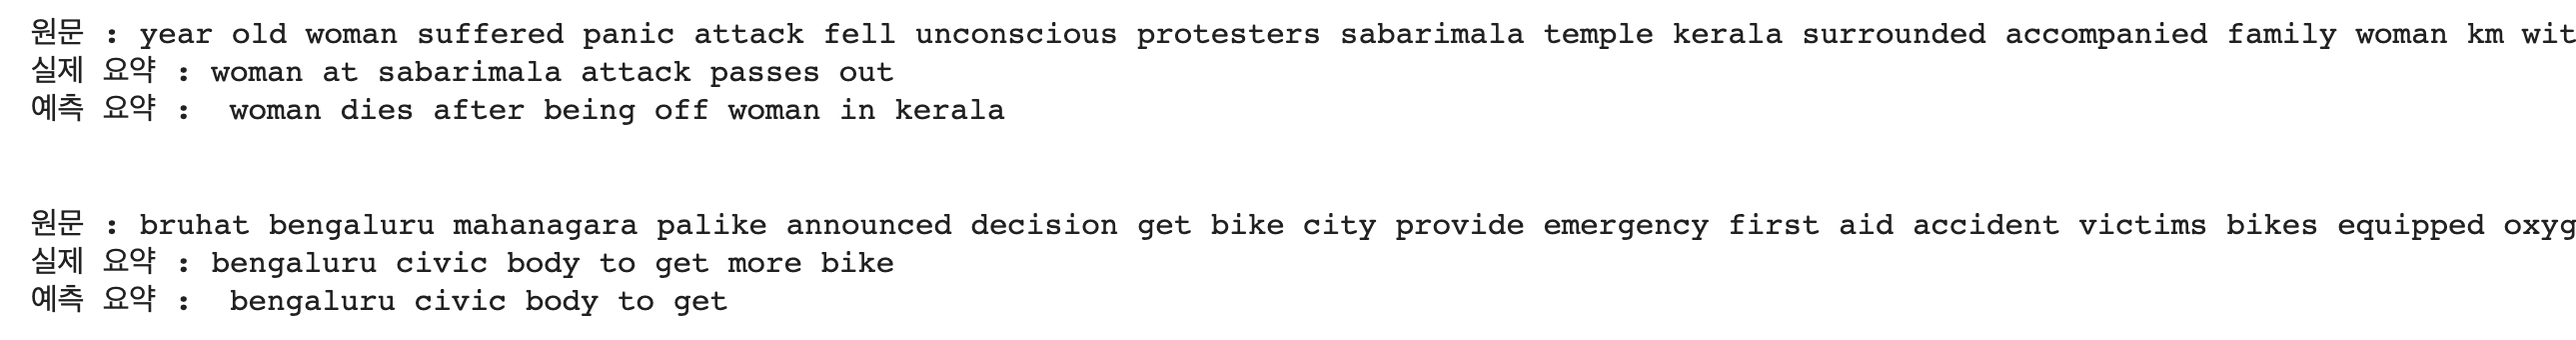

### 추상적 요약
원문 : year old woman suffered panic attack fell unconscious protesters sabarimala temple kerala surrounded accompanied family woman km without police protection protesters noticed asked id card verify age taken hospital passed 
실제 요약 : woman at sabarimala attack passes out 
예측 요약 :  woman dies after being off woman in kerala

><해석>  
원문 : 공황 발작을 겪은 1세 여성이 의식을 잃었다 시위대 사바리말라 사원 케랄라에 둘러싸여 동행한 가족 여성 경찰의 보호 없이 km 시위자들이 주목받았음 신분증 확인 나이 확인 병원 합격  
실제 요약 : 사바리말라 공격을 받고 기절한 여성  
예측 요약 : 케랄라에서 여성이 된 후 사망

원문 : bruhat bengaluru mahanagara palike announced decision get bike city provide emergency first aid accident victims bikes equipped oxygen basic drugs palike also plans operated women.   
실제 요약 : bengaluru civic body to get more bike.   
예측 요약 :  bengaluru civic body to get.  
>원문: bruhat bengaluru mahanagara palike는 자전거 도시에 긴급 응급 처치를 제공하기로 결정했다고 발표했습니다. 자전거에는 산소가 장착 된 기본 약물 palike도 여성을 운영할 계획입니다.  
실제요약: 더 많은 자전거를 얻기 위한 벵갈루루 시민 단체  
예측요약 : 벵갈루루 시민의 몸을 얻다

### 추출적 요약  
- 원문: Telangana's Cyberabad Traffic Police has sent at least 100 letters within a month informing various companies about their employees' traffic violations. "It is to inform that one of your employees was caught while driving under the influence of alcohol...he was sentenced to four days imprisonment," a letter read. DCP Vijay Kumar said the move was implemented based on public feedback.   
>Telangana의 Cyberabad 교통 경찰은 직원의 교통 위반에 대해 다양한 회사에 알리기 위해 한 달 동안 최소 100통의 편지를 보냈습니다. 편지에는 "당신의 직원 중 한 명이 만취 상태로 운전하다 적발돼 징역 4일을 선고받았다는 사실을 알리기 위한 것"이라고 적었다. DCP Vijay Kumar는 이러한 움직임이 대중의 피드백을 기반으로 구현되었다고 말했습니다.

- 비율 요약: Cyberabad Traffic Police has sent at least 100 letters within a month informing various companies about their employees' traffic violations.   
> Cyberabad 교통 경찰은 직원의 교통 위반에 대해 여러 회사에 알리는 한 달 동안 최소 100개의 편지를 보냈습니다.
- 글자 수 요약: Telangana's Cyberabad Traffic Police has sent at least 100 letters within a month informing various companies about their employees' traffic violations.
>Telangana의 Cyberabad 교통 경찰은 직원의 교통 위반에 대해 다양한 회사에 알리기 위해 한 달 동안 최소 100통의 편지를 보냈습니다.

# 회고
(1) 결과  
- 비교해보기  
  - 추상적 요약은 문법적 오류가 많고 내용의 퀄리티가 좋지 않았다
  - 추상적 요약에 비해 추출적 요약의 글이 더 매끄러워 보인다.
  - 그렇다고 추출적 요약이 핵심적인 내용을 담고있다고 생각되진 않는다

**결론적으로 추출적 요약이 추상적 요약보다 성능이 좋다고 할 수 있다**


- Epoch 시간이 정말 역대급으로 오래걸려서 숫자를 다양하게 바꿔보지 못해 아쉬웠다.
- 추상적 요약과 추출적 요약의 차이를 알 수 있었다.
- summa 패키지를 사용해보는 시간이었다

(2) 과정
프로젝트 진행 과정
1. 데이터 수집하기  
- 네이버 영화의 댓글을 모아 구성된 한국어 텍스트 감성 분석, 
뉴스 기사 데이터(news_summary_more.csv)

 
2. 데이터 전처리하기 (추상적 요약)
- 데이터 정리하기 : 중복 샘플과 NULL 값이 존재하는 샘플 제거, 텍스트 정규화와 불용어 제거  
- 훈련데이터와 테스트데이터 나누기 : 샘플의 최대 길이 정하기, 시작 토큰과 종료 토큰 추가하기  
- 정수 인코딩 : 단어 집합(vocabulary) 만들기 및 정수 인코딩
패딩하기  
- 모델 설계하기
 
3. 어텐션 메커니즘 사용하기 (추상적 요약)  
- 모델 훈련  
 
4. 실제 결과와 요약문 비교하기 (추상적 요약)  
- 인퍼런스 모델 구현하기  
- 모델 테스트하기  
- headlines 열 요약문과 추상적 요약 결과 비교  
 
5. Summa을 이용해서 추출적 요약해보기  
- Summa의 summarize를 사용하여 추출적 요약

(3)애먹었던 부분
- 마지막 추출적 요약에서 비어있는 곳이 많이 있었는데 데이터의 문제였다.
- 전처리하지 않은 데이터를 사용해 주어야한다
  - 추출적 요약 원문에서 중요한 핵심 문장 또는 단어구를 몇 개 뽑아서 이들로 구성된 요약문을 만드는 방법이다. 추출적 요약의 결과로 나온 요약문의 문장이나 단어구들은 전부 원문에 있는 문장들을 이용해야되기 때문에 전처리하지 않은 데이터를 사용해야 하는 것이다.

> 추출적 요약에서 문장을 요약해 보며 찾은 흥미로운 사실들  
 <적절한 비율 찾기>
- 비율을 적게 주어서 요약문으로 선택되는 문장의 개수를 줄이려고 여러 수치를 넣어 보았다.
- 결과적으로 원문의 약0.335%이상을 출력하는 것이 잘 나오는 것을 알 수 있었다.(약0.335% 밑의 비율로는 출력이 되지않음)  
<단어선택>  
- 1500번째 문장은 11개의 단어까지 요약이 가능했지만 10단어로 줄이니 요약문장이 나오지 않았다



## Reference

- https://wikidocs.net/72820
- https://velog.io/@yenaryu/Project-%EB%89%B4%EC%8A%A4-%EC%9A%94%EC%95%BD%EB%B4%87-%EB%A7%8C%EB%93%A4%EA%B8%B0